In [176]:
import pandas as pd
import numpy as np
from scipy import stats as st

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [177]:
# for formatted printing
end_lines = "\n"+"="*100+"\n"
sep_lines = "\n"+"-"*40+"\n"

In [178]:
# path to project: Edit here to point to your Drive
drive = '/content/drive/MyDrive/'
project_dir = 'Colab Notebooks/IronHacks2024_Data_Analytics/DA_Week_5_EDA'
COLAB_PROJECT_PATH = drive+project_dir+'/Project_week_5'

In [179]:
#Mounting Google Drive
using_colab = False
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    using_colab = True

if using_colab and os.path.exists(COLAB_PROJECT_PATH):
    print('found colab path; redirecting to main project directory')
    os.chdir(COLAB_PROJECT_PATH)

In [180]:
import sys
sys.path.append(('./Util_Functions'))

from EDA import explore_df, demo_title, data_demo, cat_vs_numerical
from KPI_Metrics import get_kpis
from Hypothesis_Test import completed_or_not, completion_with_cost_threshold, test_demo_groups, anova_gender_test

In [181]:
%reload_ext autoreload
%autoreload 2

In [182]:
dataset_dir = './Datasets'
dataset_files = []
for ds_file in os.listdir(dataset_dir):
  dataset_files.append(os.path.join(dataset_dir, ds_file))
dataset_files.sort()
dataset_files

['./Datasets\\df_final_demo.txt',
 './Datasets\\df_final_experiment_clients.txt',
 './Datasets\\df_final_web_data_pt_1.txt',
 './Datasets\\df_final_web_data_pt_2.txt']

In [183]:
# Reading my files
final_demo = pd.read_csv(dataset_files[0])
final_web_data_pt_1, final_web_data_pt_2 = pd.read_csv(dataset_files[2]), pd.read_csv(dataset_files[3])
final_experiment_clients = pd.read_csv(dataset_files[1])

In [184]:
final_web_data = pd.concat([final_web_data_pt_1, final_web_data_pt_2])
del final_web_data_pt_1, final_web_data_pt_2

In [185]:
explore_df(final_demo)

Dataframe shape: 
70609 rows X 9 columns
Dataframe data types
client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
dtype: object
Null Count:
                  count  normalize_count
client_id             0         0.000000
clnt_tenure_yr       14         0.000198
clnt_tenure_mnth     14         0.000198
clnt_age             15         0.000212
gendr                14         0.000198
num_accts            14         0.000198
bal                  14         0.000198
calls_6_mnth         14         0.000198
logons_6_mnth        14         0.000198
Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')
Value counts for each column:
client_id
836976     1
2249663    1
2405235    1
68116    

In [186]:
explore_df(final_web_data)

Dataframe shape: 
755405 rows X 5 columns
Dataframe data types
client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object
Null Count:
              count  normalize_count
client_id         0              0.0
visitor_id        0              0.0
visit_id          0              0.0
process_step      0              0.0
date_time         0              0.0
Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')
Value counts for each column:
client_id
5574879    111
2274658     90
2128341     84
5951379     81
1595223     81
          ... 
656715       1
2066750      1
1283050      1
6963245      1
674799       1
Name: count, Length: 120157, dtype: int64
----------------------------------------
visitor_id
722943003_3441581446     104
857376424_12378092455     90
272742682_16716805486     81
78799102_14329268381      80
780189529_68744403580     80
                        ... 
126345313

In [187]:
explore_df(final_experiment_clients)

Dataframe shape: 
70609 rows X 2 columns
Dataframe data types
client_id     int64
Variation    object
dtype: object
Null Count:
           count  normalize_count
client_id      0         0.000000
Variation  20109         0.284794
Index(['client_id', 'Variation'], dtype='object')
Value counts for each column:
client_id
9988021    1
4555516    1
4998932    1
3385751    1
4339267    1
          ..
7675264    1
5574016    1
573200     1
9466333    1
9895983    1
Name: count, Length: 70609, dtype: int64
----------------------------------------
Variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64
----------------------------------------


           client_id Variation
count   7.060900e+04     50500
unique           NaN         2
top              NaN      Test
freq             NaN     26968
mean    5.004992e+06       NaN
std     2.877278e+06       NaN
min     1.690000e+02       NaN
25%     2.519329e+06       NaN
50%     5.016978e+06       NaN
75%     7.48308

In [188]:
def drop_rows(df, drop_threshold=.8):
    """
      Finds rows that exceed a threshold of null values.
      By default, it returns rows with 80% of col values being null

      Arguments:
        df (pd.Dataframe) - Dataframe to find null threshold rows
        drop_threshold (float[0-1]) - threshold of nulls for which to test
      Returns: dataframe with rows exceeding threshold, which should be dropped
      """
    null_rows = df.isna().mean(axis=1)
    null_rows = null_rows[null_rows > drop_threshold]
    return df.iloc[null_rows.index]

In [189]:
def clean_data(store_to_csv:bool=False):
    """
    Cleans our datasets and gives option to store cleaned data onto csv for
    analysis outside this notebook

    arguments: store_to_csv - Flag to indicate whether to store data onto csv files
    returns: None
    """
    datasets = [final_demo, final_web_data, final_experiment_clients]
    dataset_names = ['final demo', 'final_web_data', 'final_experiment_clients']
    for data_df, name in zip(datasets, dataset_names):
        data_df.columns = data_df.columns.str.lower()
        drop_data = drop_rows(data_df)
        if not drop_data.empty:
            print(f'Rows to drop in {name}: {list(drop_data.index)}')
            data_df.drop(drop_data.index, inplace=True)

    final_experiment_clients.dropna(subset=['variation'],inplace=True)
    final_demo.fillna({'gendr':'U'}, inplace=True)
    final_demo.replace({'gendr': 'X'}, 'U', inplace=True)

    final_demo['client_tenure'] =  final_demo['clnt_tenure_mnth'] / 12

    final_web_data['date_time'] = pd.to_datetime(final_web_data['date_time'])

    clean_data_folder = './Cleaned_Datasets'
    if store_to_csv:
        names = ['final_demo', 'final_web_data', 'final_experiment_clients']
        for data_df, name in zip(datasets,names):
            data_file = os.path.join(clean_data_folder, f'clean_{name}.csv')
            data_df.to_csv(data_file, index=False)

clean_data()
final_demo['gendr'].value_counts(dropna=False)

Rows to drop in final demo: [4164, 8316, 8677, 13444, 18066, 25961, 28432, 35323, 43518, 46076, 47189, 49846, 63701, 66219]


gendr
U    24125
M    23724
F    22746
Name: count, dtype: int64

       mean  median  mode      skew  kurtosis
0  46.44224    47.0  58.5  0.081823 -0.927105
----------------------------------------


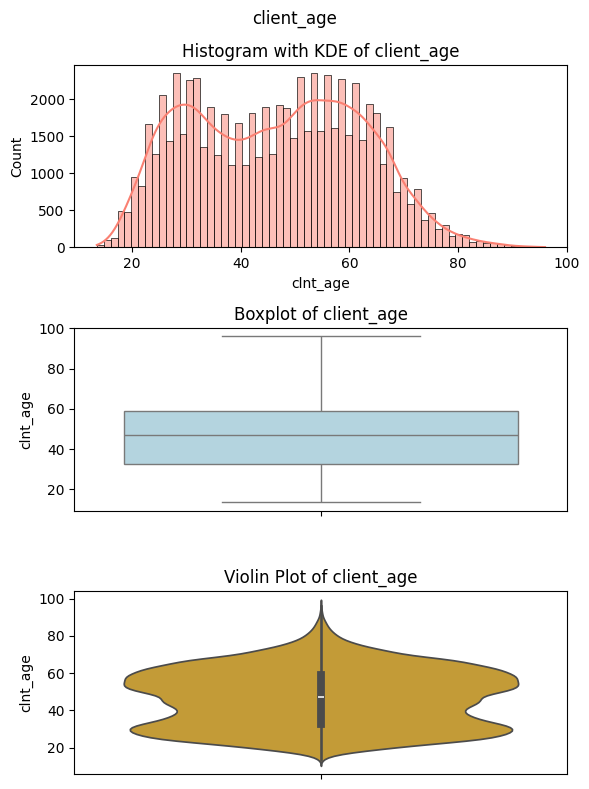

In [190]:
data_demo(final_demo, 'clnt_age')

        mean     median      mode      skew  kurtosis
0  12.554947  11.333333  4.833333  1.050673  1.102504
----------------------------------------


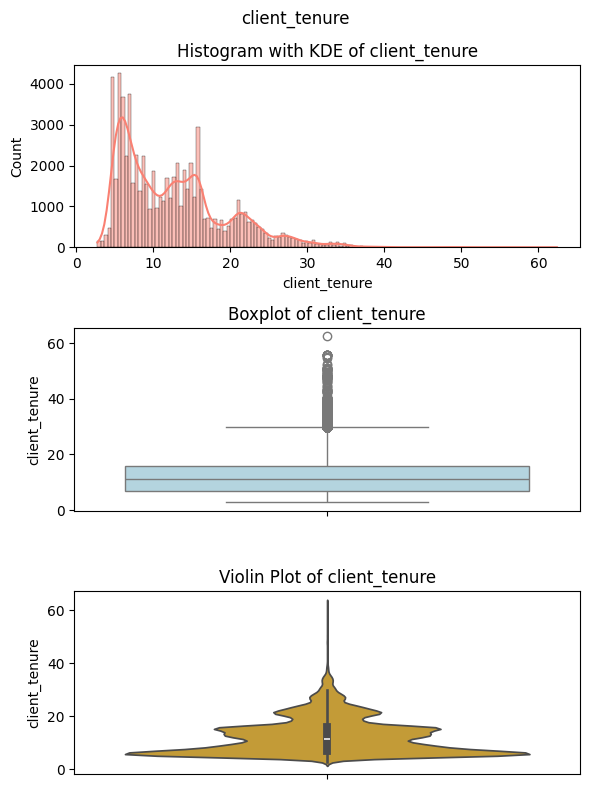

In [191]:
data_demo(final_demo, 'client_tenure')

<Axes: xlabel='num_accts', ylabel='count'>

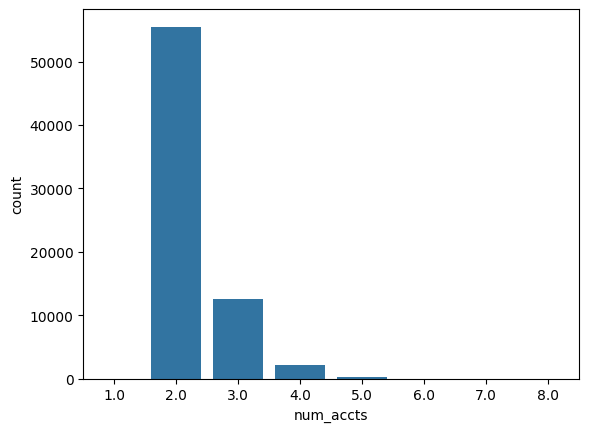

In [192]:
sns.countplot(data=final_demo, x='num_accts')

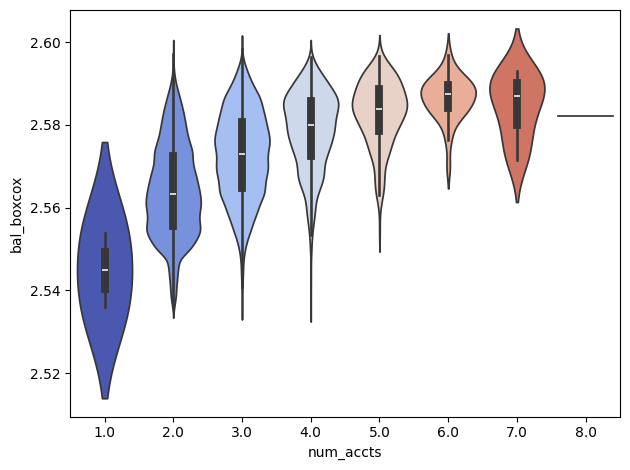

In [193]:
final_demo['bal_boxcox'], _ = st.boxcox(final_demo['bal'])
cat_vs_numerical(final_demo, 'num_accts', 'bal_boxcox')

Client Behavior Analysis:

- client age: It seems there are two demographics who most use Vanguard's online web portal/services
    - 45-59 years old: clients who are middle-age to early/mid 60s, primary demographic
    - 25-30 years old: clients who are in their mid-twenties to early thirties, secondary demographic

- client tenure: It seems in terms of tenure, their primary demographic are clients who have been with Vanguard for around 6-10 years, so clients who aren't long standing but aren't quite new either. We definitely see some outliers with some long-standing clients.

- client accts : According to the barplot, it shows that the majority of clients have around 2 accounts with Vanguard, with very few with just one account and few with with more than 5 accounts

- client balances vs num accts:
    - We see there is a logaritmic trend upwards in terms on balance as number of accounts increases.

It seems their primary clients are those who are middle aged, and clients who have had Vanguard services for around 5 to 7 years, and those have around 2 accounts.

We also see that those with more accounts tend to have larger balances.

#KPI METRICS

In [194]:
# convert datetime from string to actual datetime object
# final_web_data['date_time'] = pd.to_datetime(final_web_data['date_time'])
final_web_data.dtypes

client_id                int64
visitor_id              object
visit_id                object
process_step            object
date_time       datetime64[ns]
dtype: object

In [195]:
# For later use in Hypothesis Testing/Visualizations
web_experiment = pd.merge(final_web_data, final_experiment_clients, on='client_id', how='inner')
test_group = web_experiment[web_experiment['variation'] == 'Test']
control_group = web_experiment[web_experiment['variation'] == 'Control']

In [196]:
def display_kpi(id='client_id', overwrite:bool=False):
    """
    Utility Function to get Kpi data, store it/read it in pickle file
    """
    data_df = pd.merge(final_web_data, final_experiment_clients, on='client_id', how='inner')
    data_df['date_time'] = pd.to_datetime(data_df['date_time'])

    test = data_df[data_df['variation'] == 'Test']
    control = data_df[data_df['variation'] == 'Control']

    metric_folder = './metric_files/'
    data_file = os.path.join(metric_folder, f'KPI_Metrics_{id}.pkl')

    if overwrite or not os.path.exists(data_file):
        test_data = get_kpis(test, id)
        control_data = get_kpis(control, id)
        kpi_data = pd.concat([test_data, control_data],ignore_index=True)
        kpi_data.to_pickle(data_file)

    #print(pd.read_pickle(data_file).info())
    return pd.read_pickle(data_file)

kpi_data = {}
def run(kpi_dict):
    """Check kpis grouped client_id, visitor_id, visit_id"""
    want_to_rerun = [False, False, False]
    for group, run in zip(['client_id', 'visitor_id', 'visit_id'], want_to_rerun):
        kpi_dict[group] = display_kpi(id=group, overwrite=run)
%timeit -n 1 -r 1 run(kpi_data)

787 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [197]:
kpi_data['client_id']

,group,confirm_count,total_size,completion_rate,start_mean,step_1_mean,step_2_mean,step_3_mean,error_rate
0,Test,18395,26968,0.682105,0 days 00:20:52,0 days 00:01:00,0 days 00:09:03,0 days 00:25:09,0.263327
1,Control,15303,23532,0.650306,0 days 00:19:20,0 days 00:00:41,0 days 00:01:48,0 days 00:25:08,0.243110


In [198]:
kpi_data['visitor_id']

,group,confirm_count,total_size,completion_rate,start_mean,step_1_mean,step_2_mean,step_3_mean,error_rate
0,Test,18320,29919,0.612320,0 days 00:13:40,0 days 00:00:58,0 days 00:04:26,0 days 00:22:43,0.246830
1,Control,15243,26277,0.580089,0 days 00:11:25,0 days 00:00:40,0 days 00:01:46,0 days 00:11:30,0.224115


In [199]:
kpi_data['visit_id']

,group,confirm_count,total_size,completion_rate,start_mean,step_1_mean,step_2_mean,step_3_mean,error_rate
0,Test,18298,37136,0.492729,0 days 00:00:37,0 days 00:00:42,0 days 00:01:36,0 days 00:01:45,0.209641
1,Control,15236,32189,0.473329,0 days 00:00:42,0 days 00:00:38,0 days 00:01:42,0 days 00:02:08,0.185520


In [200]:
# For reusability onto Tableau
def convert_kpi_to_csv(id):
    base_folder = "./metric_files/"
    data_file = os.path.join(base_folder, f'Tableau_KPI_Metrics_all.csv')
    metrics = []
    for id in ['client_id', 'visitor_id','visit_id']:
        read_file = os.path.join(base_folder, f'KPI_Metrics_{id}.pkl')
        metric_data = pd.read_pickle(read_file)
        for time_delta in ['start_mean', 'step_1_mean', 'step_2_mean', 'step_3_mean']:
            metric_data[time_delta] = metric_data[time_delta].dt.total_seconds() / 60

        data_columns = list(metric_data.columns)
        metric_data['id'] = id
        metric_data = metric_data[['id'] + data_columns]
        metrics.append(metric_data)

    all_metric_data = pd.concat(metrics,ignore_index=True)
    print(all_metric_data)
    all_metric_data.to_csv(data_file)


convert_kpi_to_csv(id)

           id    group  confirm_count  total_size  completion_rate  \
0   client_id     Test          18395       26968         0.682105   
1   client_id  Control          15303       23532         0.650306   
2  visitor_id     Test          18320       29919         0.612320   
3  visitor_id  Control          15243       26277         0.580089   
4    visit_id     Test          18298       37136         0.492729   
5    visit_id  Control          15236       32189         0.473329   

   start_mean  step_1_mean  step_2_mean  step_3_mean  error_rate  
0   20.866667     1.000000     9.050000    25.150000    0.263327  
1   19.333333     0.683333     1.800000    25.133333    0.243110  
2   13.666667     0.966667     4.433333    22.716667    0.246830  
3   11.416667     0.666667     1.766667    11.500000    0.224115  
4    0.616667     0.700000     1.600000     1.750000    0.209641  
5    0.700000     0.633333     1.700000     2.133333    0.185520  


### Insights:
- completion rate :
    - test group had slighly higher completion rate at 68.2% compared to control at 65.0%.
- step duration avgs: across the board, the test group on average had taken more time on each step than the control group. particulalry in step 2
- error rate: The error rate was slightly higher with the control group than the test group

overall, while more of the test group completed the experiment, they took longer on average per step and had more errors than the control group

### Hypothesis Testing

### completion rating:
- null hypothesis - The test group's completion rate is less or equal to that of the control group
- alternative - The test group's completion rate is greater than that of the control group's

In [201]:
test_completion, control_completion = completed_or_not('client_id')
print(test_completion.mean(), control_completion.mean())

0.6821047167012756 0.6503059663437022


In [202]:
a = 0.05
stat, p_value = st.ttest_ind(test_completion, control_completion, alternative = 'greater', equal_var=False)
print(f"{stat = }, {p_value = }")
if p_value < a and stat > 0:
    print("Reject the null hypothesis: the test_completion rate is greater than the control_completion")
else:
    print("Fail to reject: not statistically significant enough to conclude test completion rate is greater than control completion or not")

stat = 7.55720915612733, p_value = 2.0946102840100895e-14
Reject the null hypothesis: the test_completion rate is greater than the control_completion


### completion rating with cost threshold:
- null hypothesis - The test group's completion rate is less or equal to that of the control group's completion rate + 5%
- alternative - The test group's completion rate is greater than that of the control group's completion rate + 5%

In [203]:
z_stat, p_value = completion_with_cost_threshold(test_completion, control_completion)
if p_value < a and z_stat > 0:
    print('statistically significant and is above cost threshold:\n the new design is justifiable and should be implemented')
else:
    if z_stat < 0:
        print('There was not enough of an increase between test and control groups to justify it')
    if not(p_value < a) and z_stat > 0:
        print('The test completion rate was not determined to be greater than the control groups.')
    print("New design is not justifiable")

Z-statistic: -4.413981367491322
P-value: 0.9999949256651329
Fail to reject null hypothesis: There is no significant difference in completion_rates between the two groups.

There was not enough of an increase between test and control groups to justify it
New design is not justifiable


### Age and client tenure group across Test and Control Groups:
- null hypothesis - Avg Age/tenure across the test & control groups is the same
- alternative - Avg Age/tenure across the test & control is not the same

In [204]:
# Merge final demo and final experiment for hypothesis testing and experiment evaluation
client_data = pd.merge(final_demo, final_experiment_clients, on='client_id', how='inner')

In [205]:
# test whether the average age of clients engaging with the new process is the same as those engaging with the old process
test_demo_groups(client_data,'clnt_age')

stat = -2.416068061200627, p_value = 0.015692719461388675
Reject the null hypothesis: the average client_age across the test/control groups aren't the same


In [206]:
client_data.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'client_tenure',
       'bal_boxcox', 'variation'],
      dtype='object')

In [207]:
# We sqrt to help account for moderate skew
client_data['client_tenure_sqrt'] = np.sqrt(client_data['client_tenure'])
test_demo_groups(client_data, 'client_tenure_sqrt')

stat = -1.6867262490913972, p_value = 0.09166230084288507
Fail to reject: the average client_tenure_sqrt across the test/control groups are probably the same


### Hypothesis test for Balance

In [208]:
client_data['bal_boxcox'],_ = st.boxcox(client_data['bal'])
test_demo_groups(client_data, 'bal_boxcox')

stat = -1.437240847290423, p_value = 0.1506558739422559
Fail to reject: the average bal_boxcox across the test/control groups are probably the same


### Hyptothesis test for Gender

In [209]:
print('Hypothesis test gender breakdown', end=end_lines)
for demo in ['clnt_age', 'client_tenure']:
    for group in ['Test', 'Control']:
        print(f"ANOVA {demo} hypothesis test")
        anova_gender_test(client_data, demo, group, a)
    print(end_lines)

Hypothesis test gender breakdown
ANOVA clnt_age hypothesis test
For the Test group
z_stat = 773.634707369704, p_value = 0.0
Reject the null hypothesis: Across gender there is significant difference in client_age

----------------------------------------

ANOVA clnt_age hypothesis test
For the Control group
z_stat = 717.9443721929886, p_value = 2.2221379317475453e-303
Reject the null hypothesis: Across gender there is significant difference in client_age

----------------------------------------



ANOVA client_tenure hypothesis test
For the Test group
z_stat = 6205.8774637222305, p_value = 0.0
Reject the null hypothesis: Across gender there is significant difference in client_tenure

----------------------------------------

ANOVA client_tenure hypothesis test
For the Control group
z_stat = 5465.059371406719, p_value = 0.0
Reject the null hypothesis: Across gender there is significant difference in client_tenure

----------------------------------------





Insights:
- completion rating: There was evidence that test group had statistically larger completion rate than control, but not when accounting for cost threshold
- average client age: there was statistical evidence to support the client ages across the groups were different
- average client tenure(transfomred by sqrt): Client tenure seems consistent across both test and control groups
- balance (boxcox) - balances seem consistent across test/client groups
- difference across gender: Through the ANOVA test, we found that:
    - There was significant differences in both the test and control groups for client age
    - there was significant difference in both test and control groups for client tenure

## Experiment Evaluation

### Design Effectiveness
- Was the experiment well-structured?
- Were clients randomly and equally divided between the old and new designs?
- Were there any biases?

In [217]:
def violin_plots(df, demo):
    test_group, control_group = df[df['variation'] == 'Test'], \
                                df[df['variation'] == 'Control']
    plots = [data_demo(test_group, demo, 'Test Group', only_violin=True, return_plot=True),
                data_demo(control_group, demo, 'Control Group', only_violin=True, return_plot=True)]
    for plot in plots:
        plot.show()

def get_gender_plot(u_df, m_df, f_df, demo, mod=''):
    fig, axes = plt.subplots(1, 3, figsize=(4, 6))  # 1 row, 3 columns
    sns.violinplot(data=u_df, y=demo, color="goldenrod", ax=axes[0])
    sns.violinplot(data=m_df, y=demo, color="blue", ax=axes[1])
    sns.violinplot(data=f_df, y=demo, color="salmon", ax=axes[2])

    full_title = f'{mod} : {demo_title(demo)} by Gender'
    axes[0].set_title('Unspecified')
    axes[1].set_title('Male')
    axes[2].set_title('Female')

    fig.suptitle(full_title)
    plt.tight_layout()
    return fig

def gender_violin_plots(df, demo):
    unspecified_gender = df[df['gendr']=='U']
    male = df[df['gendr']=='M']
    female = df[df['gendr']=='F']

    plots = []
    for group in ['Test', "Control"]:
        u_group = unspecified_gender[unspecified_gender['variation']==group]
        m_group = male[male['variation']==group]
        f_group = female[female['variation']==group]
        plots.append(get_gender_plot(u_group, m_group, f_group, demo, group))

    for plot in plots:
        plot.show()

        mean  median  mode      skew  kurtosis
0  47.163922    47.5  29.5  0.094417 -0.941896
----------------------------------------
        mean  median  mode      skew  kurtosis
0  47.498427    48.5  58.5  0.062789 -0.951699
----------------------------------------


C:\Users\maric\AppData\Local\Temp\ipykernel_29516\1506735554.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


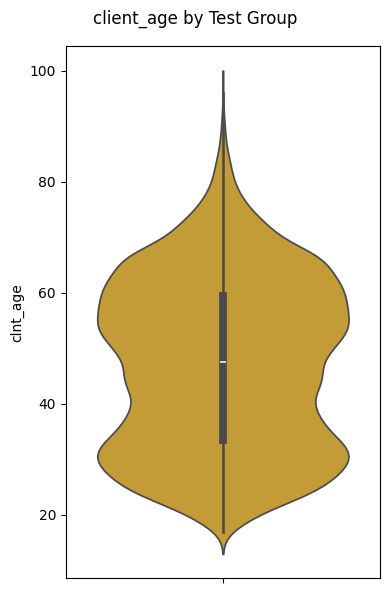

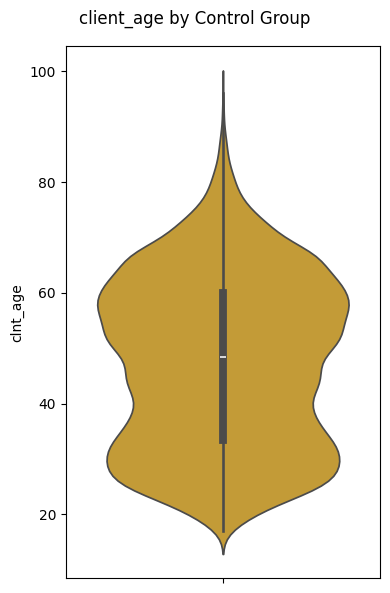

In [211]:
violin_plots(client_data, 'clnt_age')

        mean     median      mode      skew  kurtosis
0  12.487742  11.166667  4.833333  1.062755  1.127185
----------------------------------------
        mean     median      mode      skew  kurtosis
0  12.588349  11.416667  4.833333  1.026838  0.962672
----------------------------------------


C:\Users\maric\AppData\Local\Temp\ipykernel_29516\1506735554.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


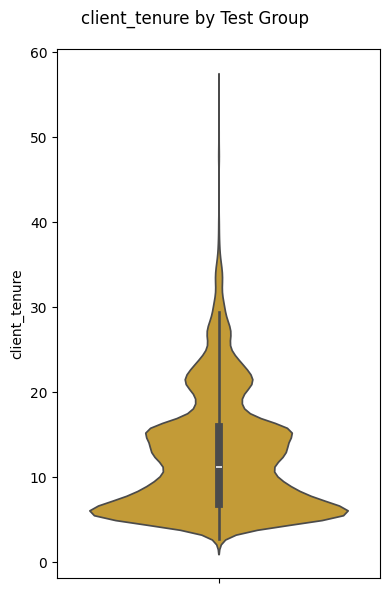

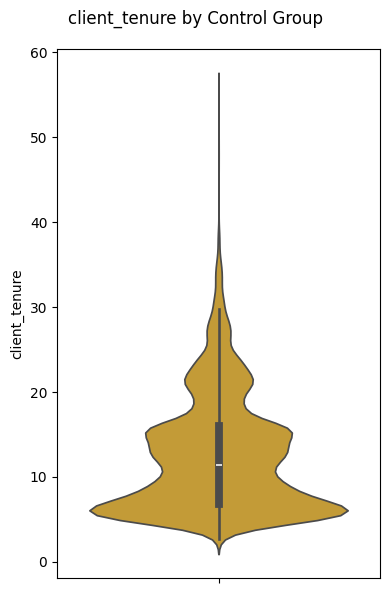

In [212]:
violin_plots(client_data,'client_tenure')

power_factor=-0.4944707210711902
       mean    median      mode     skew  kurtosis
0  2.014137  2.013961  2.009877  0.15914 -0.950714
----------------------------------------
       mean    median      mode     skew  kurtosis
0  2.014176  2.013996  2.010239  0.15718 -0.939368
----------------------------------------


C:\Users\maric\AppData\Local\Temp\ipykernel_29516\1506735554.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


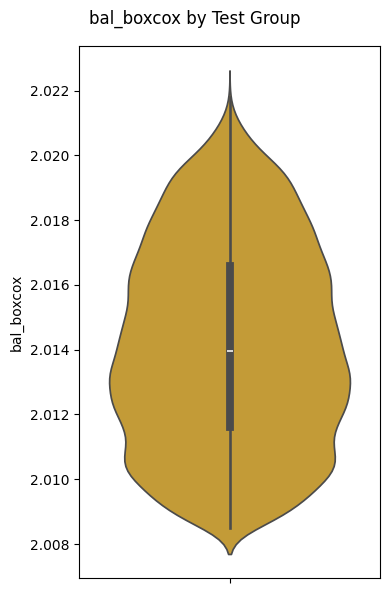

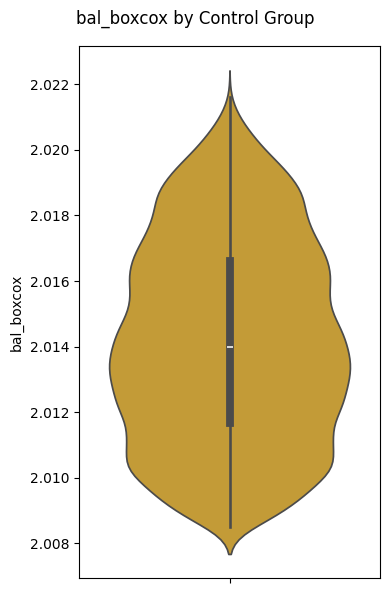

In [213]:
# box cox balance since it's extremely skewed otherwise
client_data['bal_boxcox'], power_factor = st.boxcox(client_data['bal'])
print(f'{power_factor=}')
violin_plots(client_data,'bal_boxcox')

C:\Users\maric\AppData\Local\Temp\ipykernel_29516\3982725987.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


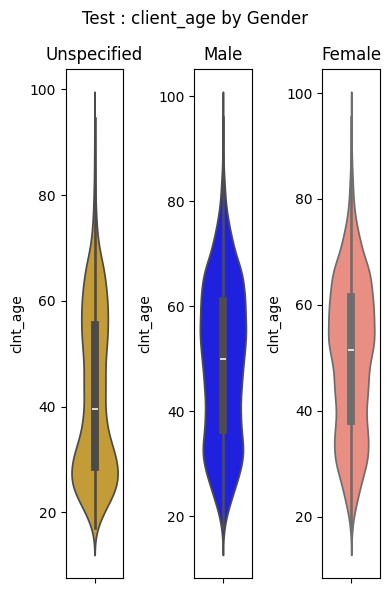

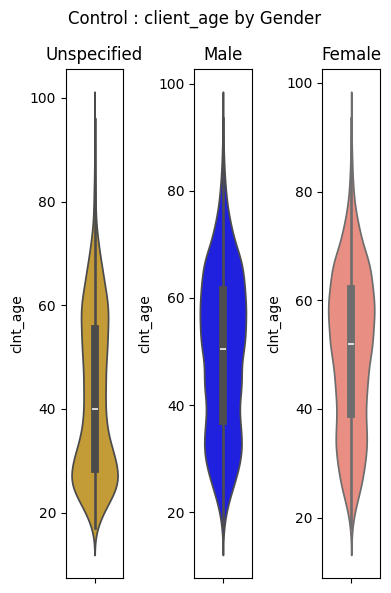

In [218]:
gender_violin_plots(client_data, 'clnt_age')

C:\Users\maric\AppData\Local\Temp\ipykernel_29516\3982725987.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


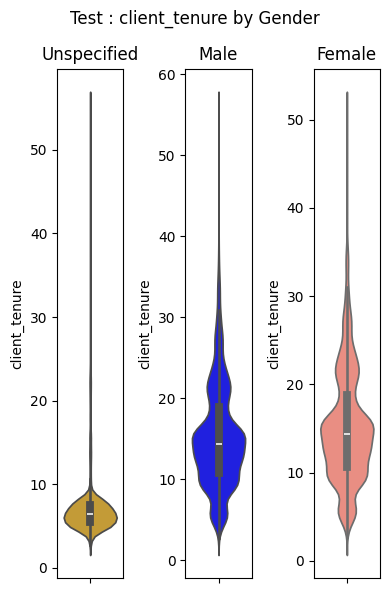

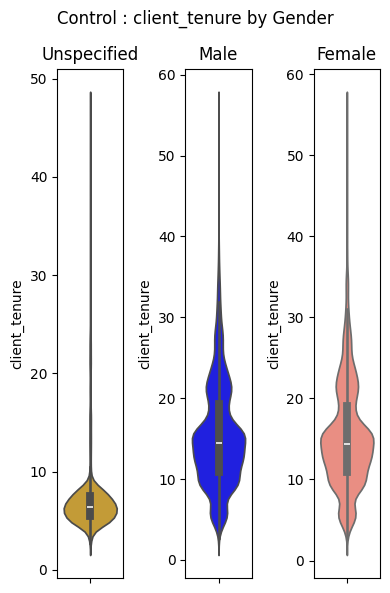

In [221]:
gender_violin_plots(client_data, 'client_tenure')

In [216]:
# For duration assessment
def each_step_once(df):
    steps = set(df['process_step'].unique()) # set of steps to complete

    has_reached_all_steps = lambda row: 1 if set(row.unique()) == steps else 0
    each_step_df = df.groupby('client_id')['process_step'].agg(has_reached_all_steps)

    return each_step_df.mean()

participation_rate = client_data['variation'].shape[0] / final_demo.shape[0] * 100

print(f"duration assesment period: {web_experiment['date_time'].min()} - {web_experiment['date_time'].max()}")
print(f"proportion of clients who particapted {participation_rate:.2f}%")

client_amount_of_steps = final_web_data['client_id'].value_counts()
print(f"proportion of total clients who logged at least each step once: {each_step_once(web_experiment):.2f}")
print(f"proportion of test clients who logged at least each step once: {each_step_once(test_group):.2f}")
print(f"proportion of control clients who logged at least each step once: {each_step_once(control_group):.2f}")

duration assesment period: 2017-03-15 00:19:28 - 2017-06-20 23:57:06
proportion of clients who particapted 71.52%
proportion of total clients who logged at least each step once: 0.66
proportion of test clients who logged at least each step once: 0.68
proportion of control clients who logged at least each step once: 0.65


## Design effectivenes:
### Was the Experiment well structured?:
We will say the experiment was not well structured for these reasons:
- there was some slight bias in client age between test and control groups:
    - particularly there was more younger clients participating in the test group seen in the violin plots and mode
- We see that There was significant differences across gender for both client age and client tenure, this probably made more of an impact.


Duration Assessment

Was the timeframe of the experiment (from 3/15/2017 to 6/20/2017) adequate to gather meaningful data and insights?

Additional Data Needs

What other data, if available, could enhance the analysis?

Duration assessment:
- The overall participation rate in the experiment is around 71%, which is a good section of their customer base
-  We see that at overall around 66% of the those who participated logged each step at least once, and that test group/control group were split more or less evenly along that.

Ultimately, the duration coincided with the Q1 2017 report, and was probably choseen to report results in the end of Q1 results. For that, the duration assessment was adequate.


Additional data needs:
- we need more context on what was different between the old design and the new design: what was the difference in terms of UI, functionality, etc.
- we need to know more about how the clients interacted with the website:
    - What they inputting or clicking on in terms of parts of the website
    - what specific parts of the website they were interacting with in terms of the old vs new design, especially for context with the steps
    - Which devices were they to test the design over: was it designed for both laptop and mobile devices.